# Optimizing our backpack - Simulated Annealing 

## A few words about the Simulated Annealing algorithm 

The Simulated Annealing algorithm is an extension of optimization algorithm based on strong analogy with the physical annealing of material. Physical annealing of material consists in bringing a solid to a low energy state after raising its temperature. We bring the solid to a very high temperature until "melting" of the structure and then we cool the solid according to a very particular temperature decreasing sheme in order to reach a state of minimum energy.In liquid phase, the particles are distributed randomly. The minimum energy state is reached if the initial temperature is sufficiently high and the cooling time is sufficiently long. An analogy is made between a multi particles system and our optimization system :
-the state space of points represent the possible states of the solid
-the function to be minimized represents the energy of the solid. So we want to obtain the state of the space of points when the function is minimized, physically its correspond to the state of the solid when th energy is minimum in the solid.




![Description de l'image](scheme.png)


## Algorithm Summary

The algorithm can be summarized as follows:

1. **Define a configuration of all possible states** `x ∈ S`, i.e., the configurational space of the problem.
2. **Define the objective function** (an energy function) `F` to minimize.
3. **Define how to determine** `x_{n+1}` from `x_n`.
4. **Evaluation of the acceptance of the newly generated state**:
   - If `F(x_{n+1}) ≤ F(x_n)`, accept `x_{n+1}`.
   - If `F(x_{n+1}) > F(x_n)`, `x_{n+1}` is accepted if `u ∼ U[0, 1] < p = exp(-ΔE / T)`. Otherwise, reject `x_{n+1}`.
     - `T` is a temperature parameter (which may correspond to physical temperature or not, depending on the problem of interest), and it is related to the probability of accepting an energy increase.
5. **A cooling schedule**, which determines how `T` evolves with the number of iterations, can be considered. If it is the case, `T_i` is updated.


In [27]:
import numpy as np
import random
import itertools
import time
import matplotlib.pyplot as plt
from IPython.display import Image





def Simulated_Annealing(v, w, W,iterations,alpha,initial_temp):
    def total_weight(selection):
        return np.dot(selection, w)

    def total_value(selection):
        return np.dot(selection, v)

    def initial_solution():
        solution = np.zeros(len(v))
        while total_weight(solution) < W:
            i = np.random.randint(0, len(v))
            solution[i] = 1
            if total_weight(solution) > W:
                solution[i] = 0
                break
        return solution

    def neighbor_solution(solution):
        neighbor = solution.copy()
        i = np.random.randint(0, len(v))
        neighbor[i] = 1 - neighbor[i]
        if total_weight(neighbor) > W:
            neighbor[i] = solution[i]
        return neighbor

    def acceptance_probability(old_value, new_value, temperature):
        if new_value > old_value:
            return 1.0
        return np.exp((new_value - old_value) / temperature)
    

    final_temp = 1
    current_solution = initial_solution()
    current_value = total_value(current_solution)
    temperature = initial_temp

    while temperature > final_temp:
        for _ in range(iterations):
            neighbor = neighbor_solution(current_solution)
            neighbor_value = total_value(neighbor)
            if acceptance_probability(current_value, neighbor_value, temperature) > np.random.rand():
                current_solution = neighbor
                current_value = neighbor_value
        temperature *= alpha

    return current_solution, current_value







## before starting

Now, let's talk a bit about the greedy algorithm. To start with, we have coded a greedy algorithm that calculates the total value of all combinations of objects whose total weight is less than or equal to the maximum weight (25 in this problem) and returns the combination of objects with the highest total value. Since this algorithm takes a lot of time (approximately 175 seconds for 25 possible objects), we coded another one that calculates the value-to-weight ratio of each object and keeps the best. This is not a "greedy" algorithm in the exact sense of the term because it does not explore all solutions, but as we can see from our test, it gives a result very close to the best result for the tested cases. To have a baseline for evaluating the simulated annealing algorithm in the case of a large number of objects (large N), we will therefore use this "pseudo-greedy" algorithm because its computation time is low (unlike the other one whose computation time makes it unusable with this computer for a large number of objects). 

In [28]:
def generate_all_combinations(N):
    return list(itertools.product([0, 1], repeat=N))

def greedy_algorithm(v, w, W):
    N = len(v)
    all_combinations = generate_all_combinations(N)
    best_alpha = np.zeros(N)
    best_cost = -1

    for vec in all_combinations:
        total_weight = np.sum(vec * w)
        total_value = np.sum(vec * v)
        if total_weight <= W and total_value > best_cost:
            best_alpha = vec
            best_cost = total_value

    total_weight = np.sum(best_alpha * w)

    return best_alpha, best_cost, total_weight



In [29]:

def greedy_algorithm2(v, w, W):
   
    value_weight_ratio = v / w
    
    
    sorted_indices = np.argsort(value_weight_ratio)[::-1]
    
    total_value = 0
    total_weight = 0
    solution = np.zeros(len(v))
    
    for i in sorted_indices:
        if total_weight + w[i] <= W:
            solution[i] = 1
            total_value += v[i]
            total_weight += w[i]
        else:
            break

    return solution, total_value

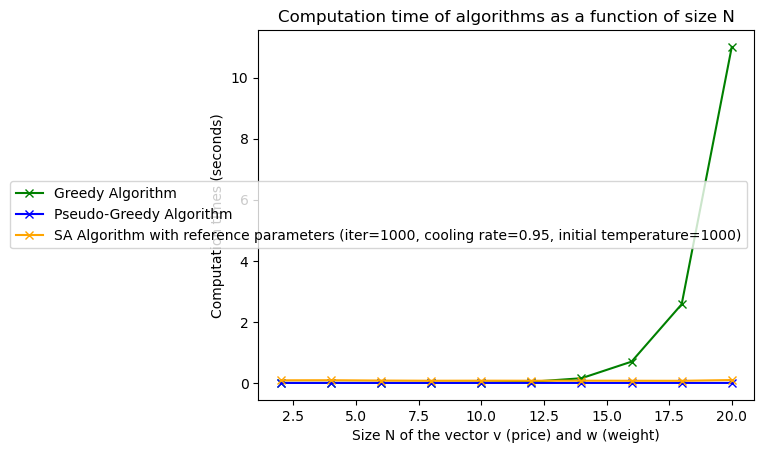

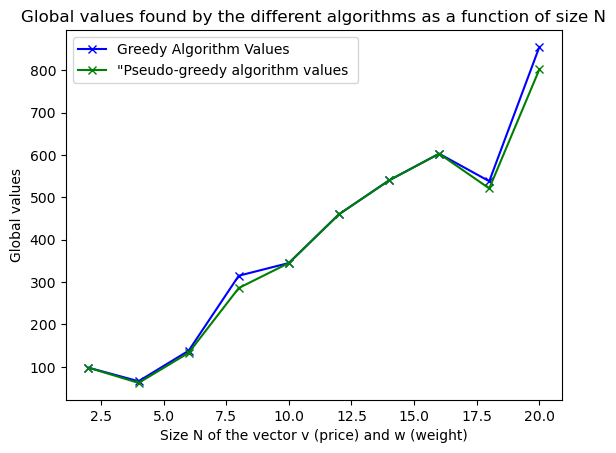

In [30]:


max_N = 20
step = 2
Ws = 25



Ns = list(range(2, max_N + 1, step))
greedy_times = []
greedy_values = []

greedy_times2 = []
greedy_values2 = []

simulated_annealing_times1= []
simulated_annealing_values1 = []



for N in Ns:
    v = np.random.randint(1, 100, N)
    w = np.random.uniform(1, 10, N)
    W = N * Ws / 10  

    start_time = time.time()
    greedy_alpha, greedy_value, greedy_weight = greedy_algorithm(v, w, W)
    greedy_times.append(time.time() - start_time)
    greedy_values.append(greedy_value)

    start_time = time.time()
    greedy_alpha2, greedy_value2, = greedy_algorithm2(v, w, W)
    greedy_times2.append(time.time() - start_time)
    greedy_values2.append(greedy_value2)

    start_time = time.time()
    best_alpha1, best_cost1 = Simulated_Annealing(v, w, W,1000,0.55,1000)
    simulated_annealing_times1.append(time.time() - start_time)
    simulated_annealing_values1.append(best_cost1)







plt.figure()
plt.plot(Ns, greedy_times, label='Greedy Algorithm',marker='x',color='green')
plt.plot(Ns, greedy_times2, label='Pseudo-Greedy Algorithm',marker='x',color='blue')
plt.plot(Ns, simulated_annealing_times1, label='SA Algorithm with reference parameters (iter=1000, cooling rate=0.95, initial temperature=1000)',marker='x',color='orange')
plt.xlabel('Size N of the vector v (price) and w (weight)')
plt.ylabel('Computation times (seconds)')
plt.title('Computation time of algorithms as a function of size N')
plt.legend()


plt.show()



plt.plot(Ns, greedy_values, label='Greedy Algorithm Values',marker='x', color='blue')
plt.plot(Ns, greedy_values2, label='"Pseudo-greedy algorithm values ', marker='x',color='green')


plt.xlabel('Size N of the vector v (price) and w (weight)')
plt.ylabel('Global values')
plt.title('Global values found by the different algorithms as a function of size N')
plt.legend()



plt.show()



## case of the exercise

In [31]:
values = np.array([23, 54, 81, 73, 45, 32, 36, 42, 33, 52, 71])
weights = np.array([3.1, 6.5, 6.9, 6.4, 5.2, 2.7, 5.5, 3.3, 4.9, 5.1, 5.8])
max_weight = 25

solutionG,best_value_greedy,total_weight=greedy_algorithm(values,weights,max_weight)
solutionSA,best_value_SA=Simulated_Annealing(values,weights,max_weight,1000,0.95,1000)

print("Best solution with greedy:", solutionG)
print("Best value with  greedy:", best_value_greedy)
print("weight of the backpack with greedy", sum(solutionG*weights))

print("Best solution with with SA:", solutionSA)
print("Best value with SA", best_value_SA)
print("weight of the backpack with greedy", sum(solutionSA*weights))

Best solution with greedy: (0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0)
Best value with  greedy: 280
weight of the backpack with greedy 24.4
Best solution with with SA: [0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.]
Best value with SA 278.0
weight of the backpack with greedy 23.8


## Analysis

Now we will study the behavior of the simulated annealing algorithm with differents numbers of objects N. Moreover we will try to see the influence of the different parameters on the results. We will keep the result of the pseudo-greedy algorithm as an indicator of the best solution (because most of time, the value obtained with the pseudo greedy algorithm is a little bit bigger than the one obtain with SA). As parameters of reference we take a final temperatur of 1000, a cooling rate of 0.95, and a number of iteration of 1000 (because the ratio time/accuracy looks good with these choices).

Let's see the influence of the cooling rate.

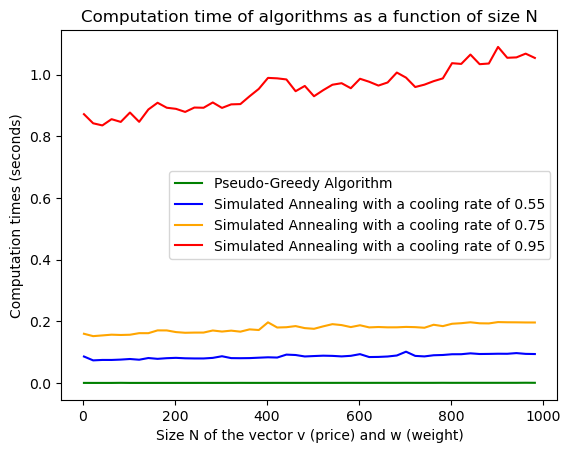

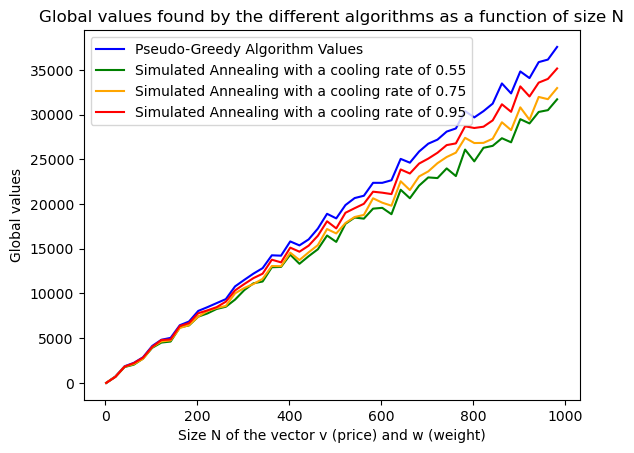

In [32]:


max_N = 1000
step = 20
Ws = 25



Ns = list(range(2, max_N + 1, step))
greedy_times = []
simulated_annealing_times1= []
greedy_values = []
simulated_annealing_values1 = []

simulated_annealing_times2 = []
simulated_annealing_values2 = []

simulated_annealing_times3 = []
simulated_annealing_values3 = []

for N in Ns:
    v = np.random.randint(1, 100, N)
    w = np.random.uniform(1, 10, N)
    W = N * Ws / 10  

    start_time = time.time()
    greedy_alpha, greedy_value = greedy_algorithm2(v, w, W)
    greedy_times.append(time.time() - start_time)
    greedy_values.append(greedy_value)

    start_time = time.time()
    best_alpha1, best_cost1 = Simulated_Annealing(v, w, W,1000,0.55,1000)
    simulated_annealing_times1.append(time.time() - start_time)
    simulated_annealing_values1.append(best_cost1)

    start_time = time.time()
    best_alpha2, best_cost2 = Simulated_Annealing(v, w, W,1000,0.75,1000)
    simulated_annealing_times2.append(time.time() - start_time)
    simulated_annealing_values2.append(best_cost2)

    start_time = time.time()
    best_alpha3, best_cost3 = Simulated_Annealing(v, w, W,1000,0.95,1000)
    simulated_annealing_times3.append(time.time() - start_time)
    simulated_annealing_values3.append(best_cost3)





plt.figure()
plt.plot(Ns, greedy_times, label='Pseudo-Greedy Algorithm',color='green')
plt.plot(Ns, simulated_annealing_times1, label='Simulated Annealing with a cooling rate of 0.55',color='blue')
plt.plot(Ns, simulated_annealing_times2, label='Simulated Annealing with a cooling rate of 0.75',color='orange')
plt.plot(Ns, simulated_annealing_times3, label='Simulated Annealing with a cooling rate of 0.95',color='red')
plt.xlabel('Size N of the vector v (price) and w (weight)')
plt.ylabel('Computation times (seconds)')
plt.title('Computation time of algorithms as a function of size N')
plt.legend()


plt.show()



plt.plot(Ns, greedy_values, label='Pseudo-Greedy Algorithm Values', color='blue')
plt.plot(Ns, simulated_annealing_values1, label='Simulated Annealing with a cooling rate of 0.55', color='green')
plt.plot(Ns, simulated_annealing_values2, label='Simulated Annealing with a cooling rate of 0.75', color='orange')
plt.plot(Ns, simulated_annealing_values3, label='Simulated Annealing with a cooling rate of 0.95',color='red')

plt.xlabel('Size N of the vector v (price) and w (weight)')
plt.ylabel('Global values')
plt.title('Global values found by the different algorithms as a function of size N')
plt.legend()



plt.show()



Let's see the influence of the number of iterations

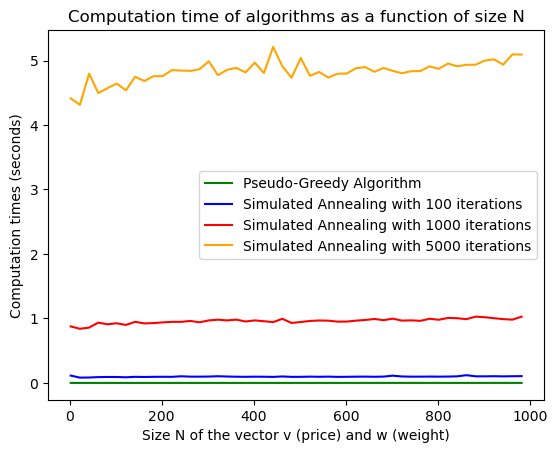

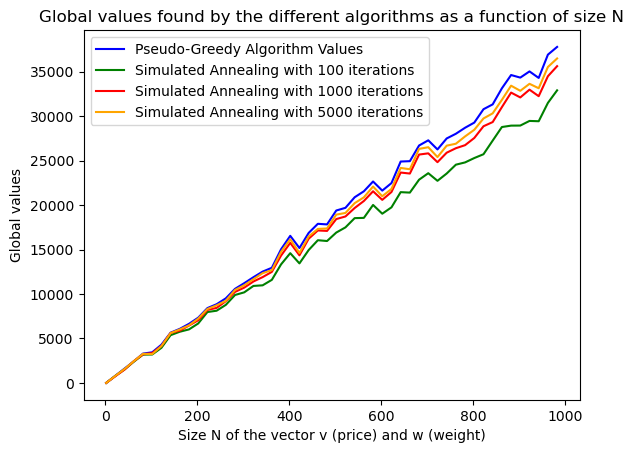

In [33]:


max_N = 1000
step = 20
Ws = 25



Ns = list(range(2, max_N + 1, step))
greedy_times = []
simulated_annealing_times1= []
greedy_values = []
simulated_annealing_values1 = []

simulated_annealing_times2 = []
simulated_annealing_values2 = []

simulated_annealing_times3 = []
simulated_annealing_values3 = []

for N in Ns:
    v = np.random.randint(1, 100, N)
    w = np.random.uniform(1, 10, N)
    W = N * Ws / 10  # Augmenter W proportionnellement à N

    start_time = time.time()
    greedy_alpha, greedy_value = greedy_algorithm2(v, w, W)
    greedy_times.append(time.time() - start_time)
    greedy_values.append(greedy_value)

    start_time = time.time()
    best_alpha1, best_cost1 = Simulated_Annealing(v, w, W,100,0.95,1000)
    simulated_annealing_times1.append(time.time() - start_time)
    simulated_annealing_values1.append(best_cost1)

    start_time = time.time()
    best_alpha2, best_cost2 = Simulated_Annealing(v, w, W,1000,0.95,1000)
    simulated_annealing_times2.append(time.time() - start_time)
    simulated_annealing_values2.append(best_cost2)

    start_time = time.time()
    best_alpha3, best_cost3 = Simulated_Annealing(v, w, W,5000,0.95,1000)
    simulated_annealing_times3.append(time.time() - start_time)
    simulated_annealing_values3.append(best_cost3)





plt.figure()
plt.plot(Ns, greedy_times, label='Pseudo-Greedy Algorithm',color='green')
plt.plot(Ns, simulated_annealing_times1, label='Simulated Annealing with 100 iterations',color='blue')
plt.plot(Ns, simulated_annealing_times2, label='Simulated Annealing with 1000 iterations',color='red')
plt.plot(Ns, simulated_annealing_times3, label='Simulated Annealing with 5000 iterations',color='orange')
plt.xlabel('Size N of the vector v (price) and w (weight)')
plt.ylabel('Computation times (seconds)')
plt.title('Computation time of algorithms as a function of size N')
plt.legend()


plt.show()



plt.plot(Ns, greedy_values, label='Pseudo-Greedy Algorithm Values', color='blue')
plt.plot(Ns, simulated_annealing_values1, label='Simulated Annealing with 100 iterations', color='green')
plt.plot(Ns, simulated_annealing_values2, label='Simulated Annealing with 1000 iterations', color='red')
plt.plot(Ns, simulated_annealing_values3, label='Simulated Annealing with 5000 iterations', color='orange')
plt.xlabel('Size N of the vector v (price) and w (weight)')
plt.ylabel('Global values')
plt.title('Global values found by the different algorithms as a function of size N')
plt.legend()



plt.show()



Let's see the influence of the initial temperature.

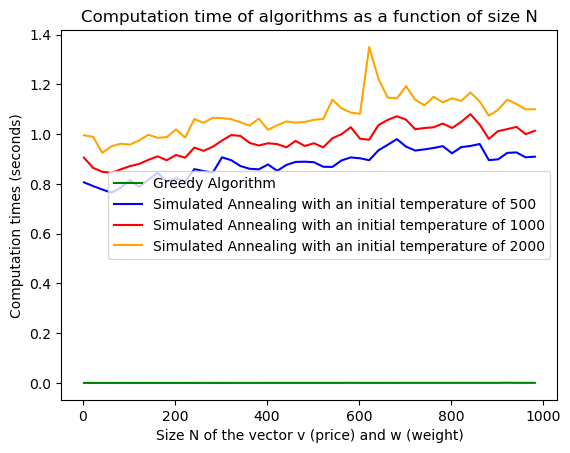

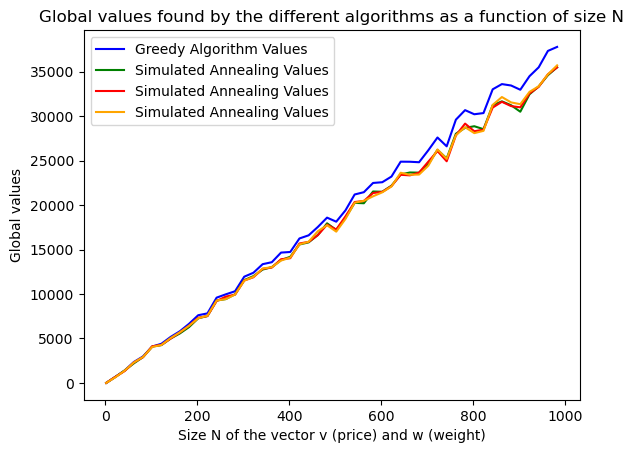

In [34]:



max_N = 1000
step = 20
Ws = 25



Ns = list(range(2, max_N + 1, step))
greedy_times = []
simulated_annealing_times1= []
greedy_values = []
simulated_annealing_values1 = []

simulated_annealing_times2 = []
simulated_annealing_values2 = []

simulated_annealing_times3 = []
simulated_annealing_values3 = []

for N in Ns:
    v = np.random.randint(1, 100, N)
    w = np.random.uniform(1, 10, N)
    W = N * Ws / 10  

    start_time = time.time()
    greedy_alpha, greedy_value = greedy_algorithm2(v, w, W)
    greedy_times.append(time.time() - start_time)
    greedy_values.append(greedy_value)

    start_time = time.time()
    best_alpha1, best_cost1 = Simulated_Annealing(v, w, W,1000,0.95,500)
    simulated_annealing_times1.append(time.time() - start_time)
    simulated_annealing_values1.append(best_cost1)

    start_time = time.time()
    best_alpha2, best_cost2 = Simulated_Annealing(v, w, W,1000,0.95,1000)
    simulated_annealing_times2.append(time.time() - start_time)
    simulated_annealing_values2.append(best_cost2)

    start_time = time.time()
    best_alpha3, best_cost3 = Simulated_Annealing(v, w, W,1000,0.95,2000)
    simulated_annealing_times3.append(time.time() - start_time)
    simulated_annealing_values3.append(best_cost3)





plt.figure()
plt.plot(Ns, greedy_times, label='Greedy Algorithm',color='green')
plt.plot(Ns, simulated_annealing_times1, label='Simulated Annealing with an initial temperature of 500',color='blue')
plt.plot(Ns, simulated_annealing_times2, label='Simulated Annealing with an initial temperature of 1000',color='red')
plt.plot(Ns, simulated_annealing_times3, label='Simulated Annealing with an initial temperature of 2000',color='orange')
plt.xlabel('Size N of the vector v (price) and w (weight)')
plt.ylabel('Computation times (seconds)')
plt.title('Computation time of algorithms as a function of size N')
plt.legend()


plt.show()



plt.plot(Ns, greedy_values, label='Greedy Algorithm Values', color='blue')
plt.plot(Ns, simulated_annealing_values1, label='Simulated Annealing Values', color='green')
plt.plot(Ns, simulated_annealing_values2, label='Simulated Annealing Values', color='red')
plt.plot(Ns, simulated_annealing_values3, label='Simulated Annealing Values', color='orange')
plt.xlabel('Size N of the vector v (price) and w (weight)')
plt.ylabel('Global values')
plt.title('Global values found by the different algorithms as a function of size N')
plt.legend()



plt.show()



## Conclusion : 

-The pseudo-greedy algorithm is better than SA in this specific case, but SA can be used for many applications where the ratio technique cannot be applied.

-SA loses accuracy when N grows larger and larger.

-The number of iterations and cooling rate have more influence on the result than the initial temperature.

-The greedy algorithm is not usable on this computer for N>30.

